Input CSV rows: 599, Output CSV rows: 1500
Merged data shape: (599, 2069)
Train shape: (479, 2004), Test shape: (120, 2004)
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0422 - loss: 0.7539 - val_accuracy: 0.0083 - val_loss: 0.7004
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0263 - loss: 0.7033 - val_accuracy: 0.0083 - val_loss: 0.7001
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0067 - loss: 0.6966 - val_accuracy: 0.0083 - val_loss: 0.6978
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0091 - loss: 0.6891 - val_accuracy: 0.0417 - val_loss: 0.6940
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0201 - loss: 0.6889 - val_accuracy: 0.0000e+00 - val_loss: 0.6965
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0341 - loss: 0.6837 - val_accuracy: 0.0083 - val_loss: 0.6972
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0119 - loss: 0.6813 - val_accuracy: 0.0083 - val_lo

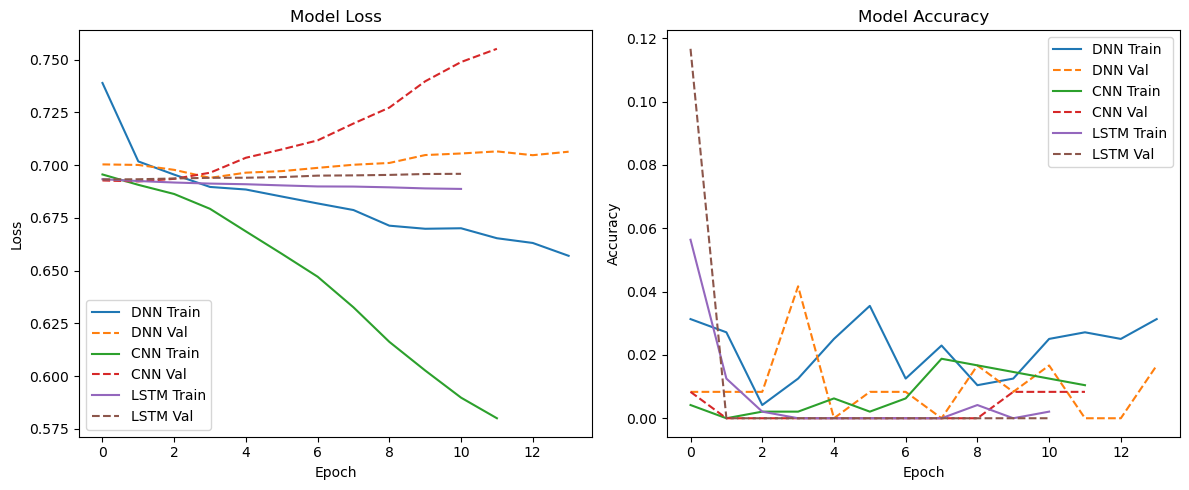

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss
import os

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 1. Load and preprocess data
def load_and_preprocess_data(input_path, output_path):
    # Load CSVs
    input_df = pd.read_csv(input_path)
    output_df = pd.read_csv(output_path)
    
    # Verify row counts
    print(f"Input CSV rows: {len(input_df)}, Output CSV rows: {len(output_df)}")
    
    # Log IDs for debugging
    input_ids = set(input_df['ID'])
    output_ids = set(output_df['ID'])
    common_ids = input_ids.intersection(output_ids)
    missing_ids = input_ids - output_ids
    if missing_ids:
        print(f"Warning: {len(missing_ids)} IDs in input file not found in output file: {sorted(missing_ids)}")
    
    # Merge on ID
    merged_df = pd.merge(input_df, output_df, on='ID', how='inner')
    print(f"Merged data shape: {merged_df.shape}")
    
    # Extract features (X) and labels (y)
    X = merged_df.iloc[:, 1:2005].values  # 2004 input columns
    y = merged_df.iloc[:, 2005:].values   # 64 output columns
    
    # Verify output is binary
    if not np.all(np.isin(y, [0, 1])):
        print("Warning: Output labels contain non-binary values")
    
    # Normalize input data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, merged_df['ID'].values

# 2. Define models
def build_dnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Train and evaluate models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                       epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    hamming = hamming_loss(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy (per output): {test_accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    # Sample predictions
    print(f"Sample predictions for {model_name} (first 5 test samples, first 10 outputs):")
    for i in range(min(5, len(y_test))):
        print(f"Sample {i+1}: True={y_test[i][:10]}, Pred={y_pred[i][:10]}")
    
    return history, test_loss, test_accuracy, hamming

# 4. Plot training history
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    output_dir = os.path.dirname('F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/')
    plt.savefig(os.path.join(output_dir, 'model_performance.png'))
    plt.show()

# 5. Main execution
def main():
    input_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/parameter1.csv'
    output_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/binary_matrices_ID.csv'
    
    # Verify file existence
    if not os.path.exists(input_path) or not os.path.exists(output_path):
        raise FileNotFoundError("Input or output CSV file not found")
    
    # Load and preprocess data
    X_train, X_test, y_train, y_test, ids = load_and_preprocess_data(input_path, output_path)
    
    # Reshape for CNN and LSTM
    X_train_cnn = X_train.reshape(X_train.shape[0], 1002, 2)  # (samples, 1002, 2)
    X_test_cnn = X_test.reshape(X_test.shape[0], 1002, 2)
    
    # Build and train models
    dnn_model = build_dnn(input_dim=2004)
    cnn_model = build_cnn(input_shape=(1002, 2))
    lstm_model = build_lstm(input_shape=(1002, 2))
    
    models = [dnn_model, cnn_model, lstm_model]
    model_names = ['DNN', 'CNN', 'LSTM']
    histories = []
    results = []
    
    for model, name in zip(models, model_names):
        X_train_input = X_train_cnn if name in ['CNN', 'LSTM'] else X_train
        X_test_input = X_test_cnn if name in ['CNN', 'LSTM'] else X_test
        history, test_loss, test_accuracy, hamming = train_and_evaluate_model(
            model, X_train_input, X_test_input, y_train, y_test, name
        )
        histories.append(history)
        results.append((name, test_loss, test_accuracy, hamming))
    
    # Compare results
    print("\nModel Comparison:")
    print("Model\tTest Loss\tTest Accuracy\tHamming Loss")
    for name, test_loss, test_accuracy, hamming in results:
        print(f"{name}\t{test_loss:.4f}\t{test_accuracy:.4f}\t{hamming:.4f}")
    
    # Plot training history
    plot_history(histories, model_names)

if __name__ == "__main__":
    main()

Input CSV rows: 599, Output CSV rows: 1500
Merged data shape: (599, 2069)
Class balance (mean 1s per output): 0.5029 ± 0.0202
PCA reduced to 100 components, explained variance ratio: 0.9976
Train shape: (479, 100), Test shape: (120, 100)
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0039 - loss: 1.5903 - val_accuracy: 0.0083 - val_loss: 1.0080
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0032 - loss: 1.4128 - val_accuracy: 0.0083 - val_loss: 0.9239
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0031 - loss: 1.2704 - val_accuracy: 0.0083 - val_loss: 0.8680
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0030 - loss: 1.1970 - val_accuracy: 0.0083 - val_loss: 0.8293
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0135 - loss: 1.1014 - val_accuracy: 0.0083 - val_loss: 0.8006
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0124 - loss: 1.0503 - val_accuracy: 0.0083 - val_loss: 0.7778


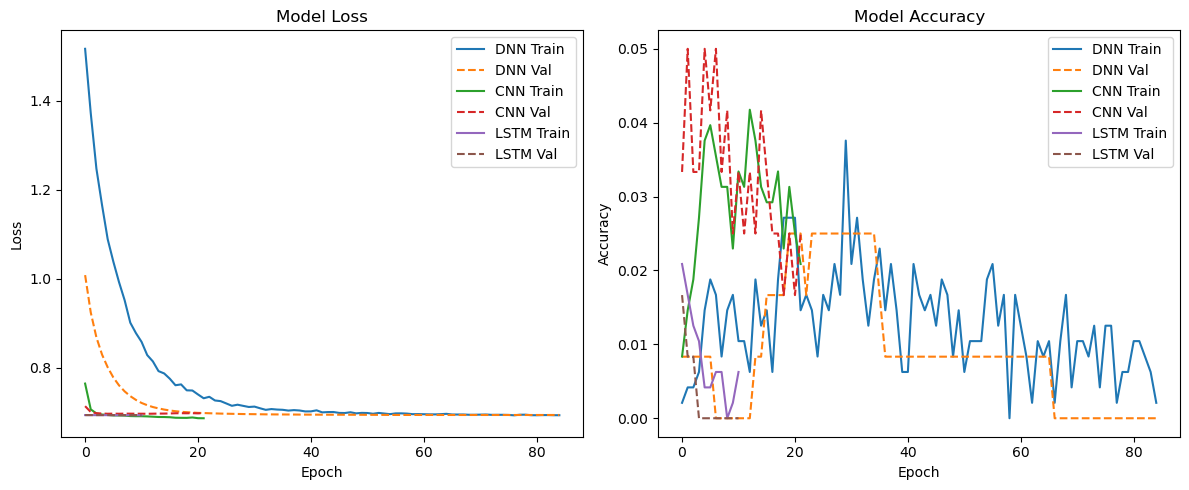

Saved DNN predictions to DNN_predictions.csv
Saved CNN predictions to CNN_predictions.csv
Saved LSTM predictions to LSTM_predictions.csv
Saved Logistic Regression predictions to Logistic Regression_predictions.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 1. Load and preprocess data
def load_and_preprocess_data(input_path, output_path, n_components=100):
    input_df = pd.read_csv(input_path)
    output_df = pd.read_csv(output_path)
    
    print(f"Input CSV rows: {len(input_df)}, Output CSV rows: {len(output_df)}")
    
    # Log IDs for debugging
    input_ids = set(input_df['ID'])
    output_ids = set(output_df['ID'])
    common_ids = input_ids.intersection(output_ids)
    missing_ids = input_ids - output_ids
    if missing_ids:
        print(f"Warning: {len(missing_ids)} IDs in input file not found in output file: {sorted(missing_ids)}")
    
    # Merge on ID
    merged_df = pd.merge(input_df, output_df, on='ID', how='inner')
    print(f"Merged data shape: {merged_df.shape}")
    
    # Extract features (X) and labels (y)
    X = merged_df.iloc[:, 1:2005].values  # 2004 input columns
    y = merged_df.iloc[:, 2005:].values   # 64 output columns
    
    # Verify output is binary
    if not np.all(np.isin(y, [0, 1])):
        print("Warning: Output labels contain non-binary values")
    
    # Check class imbalance
    class_counts = np.mean(y, axis=0)
    print(f"Class balance (mean 1s per output): {np.mean(class_counts):.4f} ± {np.std(class_counts):.4f}")
    
    # Normalize and apply PCA
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    if n_components:
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)
        print(f"PCA reduced to {n_components} components, explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, merged_df['ID'].values

# 2. Define models
def build_dnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Train and evaluate models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, epochs=100, batch_size=16):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                       epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    hamming = hamming_loss(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy (per output): {test_accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    # Sample predictions
    print(f"Sample predictions for {model_name} (first 5 test samples, first 10 outputs):")
    for i in range(min(5, len(y_test))):
        print(f"Sample {i+1}: True={y_test[i][:10]}, Pred={y_pred[i][:10]}")
    
    return history, test_loss, test_accuracy, hamming, y_pred

# 4. Train and evaluate Logistic Regression baseline
def train_logistic_regression(X_train, X_test, y_train, y_test):
    model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    hamming = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred, normalize=True)
    
    print("\nLogistic Regression Results:")
    print(f"Test Accuracy (per output): {accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    # Sample predictions
    print(f"Sample predictions for Logistic Regression (first 5 test samples, first 10 outputs):")
    for i in range(min(5, len(y_test))):
        print(f"Sample {i+1}: True={y_test[i][:10]}, Pred={y_pred[i][:10]}")
    
    return None, None, accuracy, hamming, y_pred

# 5. Plot training history
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        if history is not None:
            plt.plot(history.history['loss'], label=f'{name} Train')
            plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        if history is not None:
            plt.plot(history.history['accuracy'], label=f'{name} Train')
            plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    output_dir = os.path.dirname('F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/')
    plt.savefig(os.path.join(output_dir, 'model_performance_improved.png'))
    plt.show()

# 6. Save predictions
def save_predictions(y_test, y_preds, model_names, ids_test):
    output_dir = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/'
    for y_pred, name in zip(y_preds, model_names):
        pred_df = pd.DataFrame(y_pred, columns=[f'm_{i+1}' for i in range(64)])
        pred_df['ID'] = ids_test
        pred_df.to_csv(os.path.join(output_dir, f'{name}_predictions.csv'), index=False)
        print(f"Saved {name} predictions to {name}_predictions.csv")

# 7. Main execution
def main():
    input_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/parameter1.csv'
    output_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/binary_matrices_ID.csv'
    
    if not os.path.exists(input_path) or not os.path.exists(output_path):
        raise FileNotFoundError("Input or output CSV file not found")
    
    # Load and preprocess data
    X_train, X_test, y_train, y_test, ids = load_and_preprocess_data(input_path, output_path, n_components=100)
    ids_test = ids[-len(y_test):]  # IDs for test set
    
    # Reshape for CNN and LSTM
    X_train_cnn = X_train.reshape(X_train.shape[0], 100, 1)  # (samples, 100, 1) after PCA
    X_test_cnn = X_test.reshape(X_test.shape[0], 100, 1)
    
    # Build and train models
    dnn_model = build_dnn(input_dim=100)
    cnn_model = build_cnn(input_shape=(100, 1))
    lstm_model = build_lstm(input_shape=(100, 1))
    
    models = [dnn_model, cnn_model, lstm_model]
    model_names = ['DNN', 'CNN', 'LSTM', 'Logistic Regression']
    histories = []
    results = []
    y_preds = []
    
    # Train deep learning models
    for model, name in zip(models, model_names[:3]):
        X_train_input = X_train_cnn if name in ['CNN', 'LSTM'] else X_train
        X_test_input = X_test_cnn if name in ['CNN', 'LSTM'] else X_test
        history, test_loss, test_accuracy, hamming, y_pred = train_and_evaluate_model(
            model, X_train_input, X_test_input, y_train, y_test, name, epochs=100, batch_size=16
        )
        histories.append(history)
        results.append((name, test_loss, test_accuracy, hamming))
        y_preds.append(y_pred)
    
    # Train Logistic Regression baseline
    history, test_loss, test_accuracy, hamming, y_pred = train_logistic_regression(X_train, X_test, y_train, y_test)
    histories.append(None)
    results.append(('Logistic Regression', test_loss, test_accuracy, hamming))
    y_preds.append(y_pred)
    
    # Compare results
    print("\nModel Comparison:")
    print("Model\tTest Loss\tTest Accuracy\tHamming Loss")
    for name, test_loss, test_accuracy, hamming in results:
        if test_loss is None:
            print(f"{name}\tN/A\t{test_accuracy:.4f}\t{hamming:.4f}")
        else:
            print(f"{name}\t{test_loss:.4f}\t{test_accuracy:.4f}\t{hamming:.4f}")
    
    # Plot training history
    plot_history(histories, model_names)
    
    # Save predictions
    save_predictions(y_test, y_preds, model_names, ids_test)

if __name__ == "__main__":
    main()

Input CSV rows: 599, Output CSV rows: 1500
Input IDs range: 1.0 to 600.0
Output IDs range: 1 to 1500
Merged data shape: (599, 2069)
Class balance (mean 1s per output): 0.5029 ± 0.0202
Features after variance thresholding: 1734
PCA reduced to 50 components, explained variance ratio: 0.9753
Augmented data shape: (1797, 50)
Train shape: (1437, 50), Test shape: (360, 50)
Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0183 - loss: 2.0145 - val_accuracy: 0.0111 - val_loss: 1.1344
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0297 - loss: 1.9406 - val_accuracy: 0.0111 - val_loss: 1.0915
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0143 - loss: 1.8760 - val_accuracy: 0.0111 - val_loss: 1.0537
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0145 - loss: 1.8298 - val_accuracy: 0.0139 - val_loss: 1.0200
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0264 - loss: 1.7348 - val_accuracy: 0.0139 - val_loss: 0.

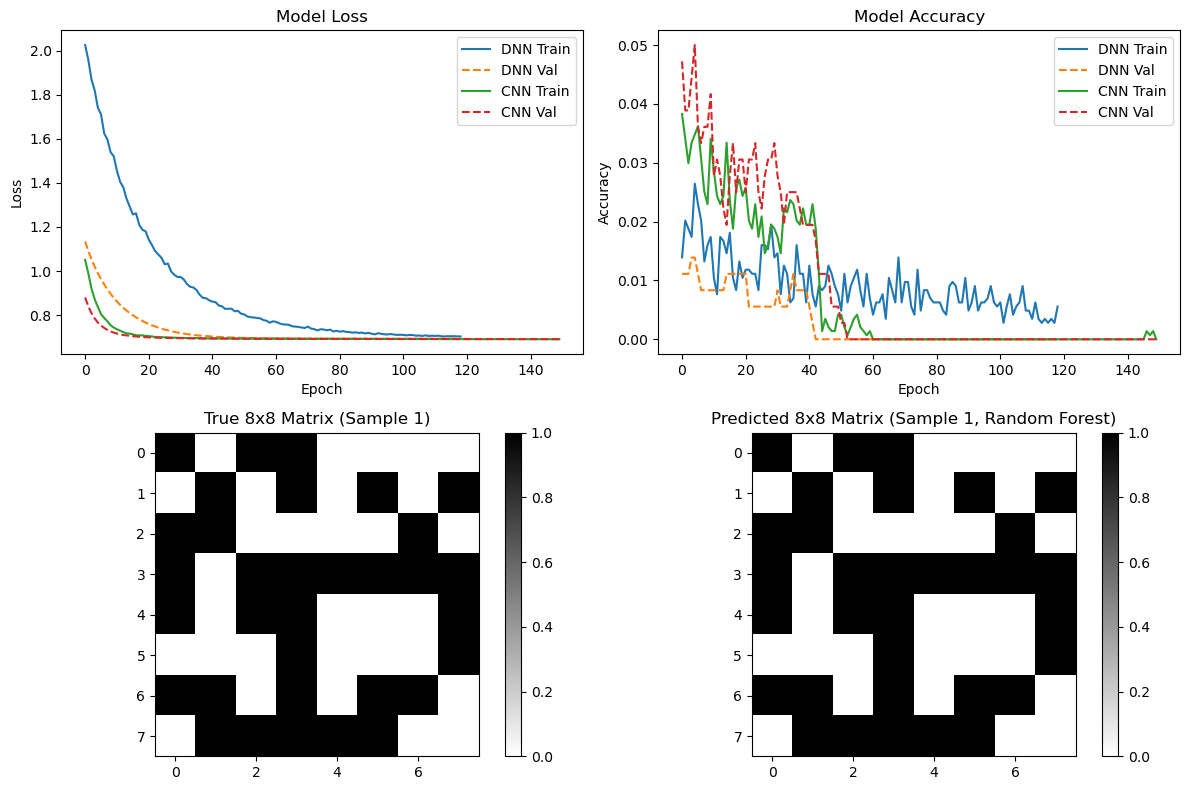

Saved DNN predictions to DNN_predictions.csv
Saved CNN predictions to CNN_predictions.csv
Saved Random Forest predictions to Random Forest_predictions.csv


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 1. Load and preprocess data
def load_and_preprocess_data(input_path, output_path, n_components=50, augment_factor=3):
    input_df = pd.read_csv(input_path)
    output_df = pd.read_csv(output_path)
    
    print(f"Input CSV rows: {len(input_df)}, Output CSV rows: {len(output_df)}")
    
    # Verify data quality
    print(f"Input IDs range: {input_df['ID'].min()} to {input_df['ID'].max()}")
    print(f"Output IDs range: {output_df['ID'].min()} to {output_df['ID'].max()}")
    if not np.all(np.isin(output_df.iloc[:, 1:], [0, 1])):
        print("Warning: Output labels contain non-binary values")
    
    # Log IDs for debugging
    input_ids = set(input_df['ID'])
    output_ids = set(output_df['ID'])
    missing_ids = input_ids - output_ids
    if missing_ids:
        print(f"Warning: {len(missing_ids)} IDs in input file not found in output file: {sorted(missing_ids)}")
    
    # Merge on ID
    merged_df = pd.merge(input_df, output_df, on='ID', how='inner')
    print(f"Merged data shape: {merged_df.shape}")
    
    # Extract features (X) and labels (y)
    X = merged_df.iloc[:, 1:2005].values  # 2004 input columns
    y = merged_df.iloc[:, 2005:].values   # 64 output columns
    
    # Check class balance
    class_counts = np.mean(y, axis=0)
    print(f"Class balance (mean 1s per output): {np.mean(class_counts):.4f} ± {np.std(class_counts):.4f}")
    
    # Feature selection: remove low-variance features
    selector = VarianceThreshold(threshold=0.01)
    X = selector.fit_transform(X)
    print(f"Features after variance thresholding: {X.shape[1]}")
    
    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # PCA
    if n_components:
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)
        print(f"PCA reduced to {n_components} components, explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Data augmentation
    if augment_factor > 1:
        X_aug = np.concatenate([X] + [X + np.random.normal(0, 0.01, X.shape) for _ in range(augment_factor-1)])
        y_aug = np.concatenate([y] * augment_factor)
        print(f"Augmented data shape: {X_aug.shape}")
        X, y = X_aug, y_aug
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, merged_df['ID'].values

# 2. Define models
def build_dnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(8, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Train and evaluate models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, epochs=150, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                       epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    hamming = hamming_loss(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy (per output): {test_accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    # Sample predictions
    print(f"Sample predictions for {model_name} (first 5 test samples, first 10 outputs):")
    for i in range(min(5, len(y_test))):
        print(f"Sample {i+1}: True={y_test[i][:10]}, Pred={y_pred[i][:10]}")
    
    return history, test_loss, test_accuracy, hamming, y_pred

# 4. Train and evaluate Random Forest with GridSearchCV
def train_random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [5, 10, None],
        'estimator__min_samples_split': [2, 5]
    }
    model = MultiOutputClassifier(rf)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    hamming = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred, normalize=True)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\nRandom Forest Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Test Accuracy (per output): {accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"5-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Sample predictions
    print(f"Sample predictions for Random Forest (first 5 test samples, first 10 outputs):")
    for i in range(min(5, len(y_test))):
        print(f"Sample {i+1}: True={y_test[i][:10]}, Pred={y_pred[i][:10]}")
    
    return None, None, accuracy, hamming, y_pred

# 5. Plot training history and sample matrices
def plot_history_and_matrices(histories, model_names, y_test, y_preds):
    plt.figure(figsize=(12, 8))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    for history, name in zip(histories, model_names):
        if history is not None:
            plt.plot(history.history['loss'], label=f'{name} Train')
            plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    for history, name in zip(histories, model_names):
        if history is not None:
            plt.plot(history.history['accuracy'], label=f'{name} Train')
            plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot sample true vs predicted matrices
    plt.subplot(2, 2, 3)
    plt.imshow(y_test[0].reshape(8, 8), cmap='binary')
    plt.title('True 8x8 Matrix (Sample 1)')
    plt.colorbar()
    
    plt.subplot(2, 2, 4)
    plt.imshow(y_preds[-1][0].reshape(8, 8), cmap='binary')  # Use Random Forest predictions
    plt.title(f'Predicted 8x8 Matrix (Sample 1, Random Forest)')
    plt.colorbar()
    
    plt.tight_layout()
    output_dir = os.path.dirname('F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/')
    plt.savefig(os.path.join(output_dir, 'model_performance_optimized.png'))
    plt.show()

# 6. Save predictions
def save_predictions(y_test, y_preds, model_names, ids_test):
    output_dir = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/'
    for y_pred, name in zip(y_preds, model_names):
        pred_df = pd.DataFrame(y_pred, columns=[f'm_{i+1}' for i in range(64)])
        pred_df['ID'] = ids_test[:len(y_pred)]  # Adjust for augmented test set
        pred_df.to_csv(os.path.join(output_dir, f'{name}_predictions.csv'), index=False)
        print(f"Saved {name} predictions to {name}_predictions.csv")

# 7. Main execution
def main():
    input_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/parameter1.csv'
    output_path = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/binary_matrices_ID.csv'
    
    if not os.path.exists(input_path) or not os.path.exists(output_path):
        raise FileNotFoundError("Input or output CSV file not found")
    
    # Load and preprocess data
    X_train, X_test, y_train, y_test, ids = load_and_preprocess_data(input_path, output_path, n_components=50, augment_factor=3)
    ids_test = ids[-len(y_test):]  # IDs for test set
    
    # Reshape for CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], 50, 1)  # (samples, 50, 1) after PCA
    X_test_cnn = X_test.reshape(X_test.shape[0], 50, 1)
    
    # Build and train models
    dnn_model = build_dnn(input_dim=50)
    cnn_model = build_cnn(input_shape=(50, 1))
    
    models = [dnn_model, cnn_model]
    model_names = ['DNN', 'CNN', 'Random Forest']
    histories = []
    results = []
    y_preds = []
    
    # Train deep learning models
    for model, name in zip(models, model_names[:2]):
        X_train_input = X_train_cnn if name == 'CNN' else X_train
        X_test_input = X_test_cnn if name == 'CNN' else X_test
        history, test_loss, test_accuracy, hamming, y_pred = train_and_evaluate_model(
            model, X_train_input, X_test_input, y_train, y_test, name, epochs=150, batch_size=32
        )
        histories.append(history)
        results.append((name, test_loss, test_accuracy, hamming))
        y_preds.append(y_pred)
    
    # Train Random Forest
    history, test_loss, test_accuracy, hamming, y_pred = train_random_forest(X_train, X_test, y_train, y_test)
    histories.append(None)
    results.append(('Random Forest', test_loss, test_accuracy, hamming))
    y_preds.append(y_pred)
    
    # Compare results
    print("\nModel Comparison:")
    print("Model\tTest Loss\tTest Accuracy\tHamming Loss")
    for name, test_loss, test_accuracy, hamming in results:
        if test_loss is None:
            print(f"{name}\tN/A\t{test_accuracy:.4f}\t{hamming:.4f}")
        else:
            print(f"{name}\t{test_loss:.4f}\t{test_accuracy:.4f}\t{hamming:.4f}")
    
    # Plot training history and matrices
    plot_history_and_matrices(histories, model_names, y_test, y_preds)
    
    # Save predictions
    save_predictions(y_test, y_preds, model_names, ids_test)

if __name__ == "__main__":
    main()